In [1]:
from HurdatReader import *
from PlotPaths import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
import numpy as np
hurdat = readHurdat('Data/Hurdat.txt')

In [2]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    From https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    miles = 3958.8 * c
    return miles

In [3]:
def count_storms_in_radius(hurdat, lon, lat, radius, stormType, lon_min=-180, lon_max=180, lat_min=-90, lat_max=90):
    count = 0
    for storm in hurdat:
        series = haversine_np(lon, lat, hurdat[storm]['data']['lon'], hurdat[storm]['data']['lat'])
        min_dist = np.min(series)
        if min_dist < radius and statusNearLocation(hurdat[storm], lon_min, lon_max, lat_min, lat_max) in stormType:
            count +=1        
    
    return count

In [4]:
def plot_prob_dist(hurdat, stormType, lon_min=-180, lon_max=180, lat_min=-90, lat_max=90, 
                   bounds = None, saveFig = None, resolution=1, count_radius = 40, ):
    hurdat = trimHurdat(hurdat, lonMin = lon_min, lonMax = lon_max, latMin = lat_min, latMax = lat_max)
    
    if stormType == 'all':
        stormType = ['TD', 'HU1', 'HU2', 'HU3', 'HU4', 'HU5', 'HUU', 'TS+', 'TS-', 'SS', 'EX']
    if stormType == 'hurricanes':
        stormType = ['HU1', 'HU2', 'HU3', 'HU4', 'HU5', 'HUU']
    if stormType == 'tropical storms':
        stormType = ['TS+', 'TS-']
    
    fig = plt.figure(figsize = (20,20))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ax.coastlines()
    if bounds is None:
        bounds = [-100, -30, 10, 80]
    
    lon_min, lon_max, lat_min, lat_max = bounds
    x_list = np.arange(lon_min, lon_max, resolution)
    y_list = np.arange(lat_min, lat_max, resolution)
    print(len(x_list) * len(y_list))
    xx, yy = np.meshgrid(x_list, y_list)
    coords = np.dstack((xx,yy))
    count = [[count_storms_in_radius(hurdat, *coordpair, count_radius, stormType, 
                                     lon_min, lon_max, lat_min, lat_max) for coordpair in row] for row in tqdm(coords)]
    
    ax.set_title(F'Frequency heatmap of past {stormType} tracks with {resolution} degree resolution and {count_radius} mile search radius')
    
    if np.max(count) > 1: 
        levels = np.arange(0, np.max(count)+1, 1)
        im = ax.contourf(x_list, y_list, count, levels = levels)
    else:
        im = ax.contourf(x_list, y_list, count)
    
    
    
    plt.colorbar(im)

    ax.set_extent(bounds, crs=ccrs.Geodetic())
    
    if not saveFig is None:
        plt.savefig(saveFig)
    
    plt.show()

4900


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [05:42<00:00,  4.89s/it]


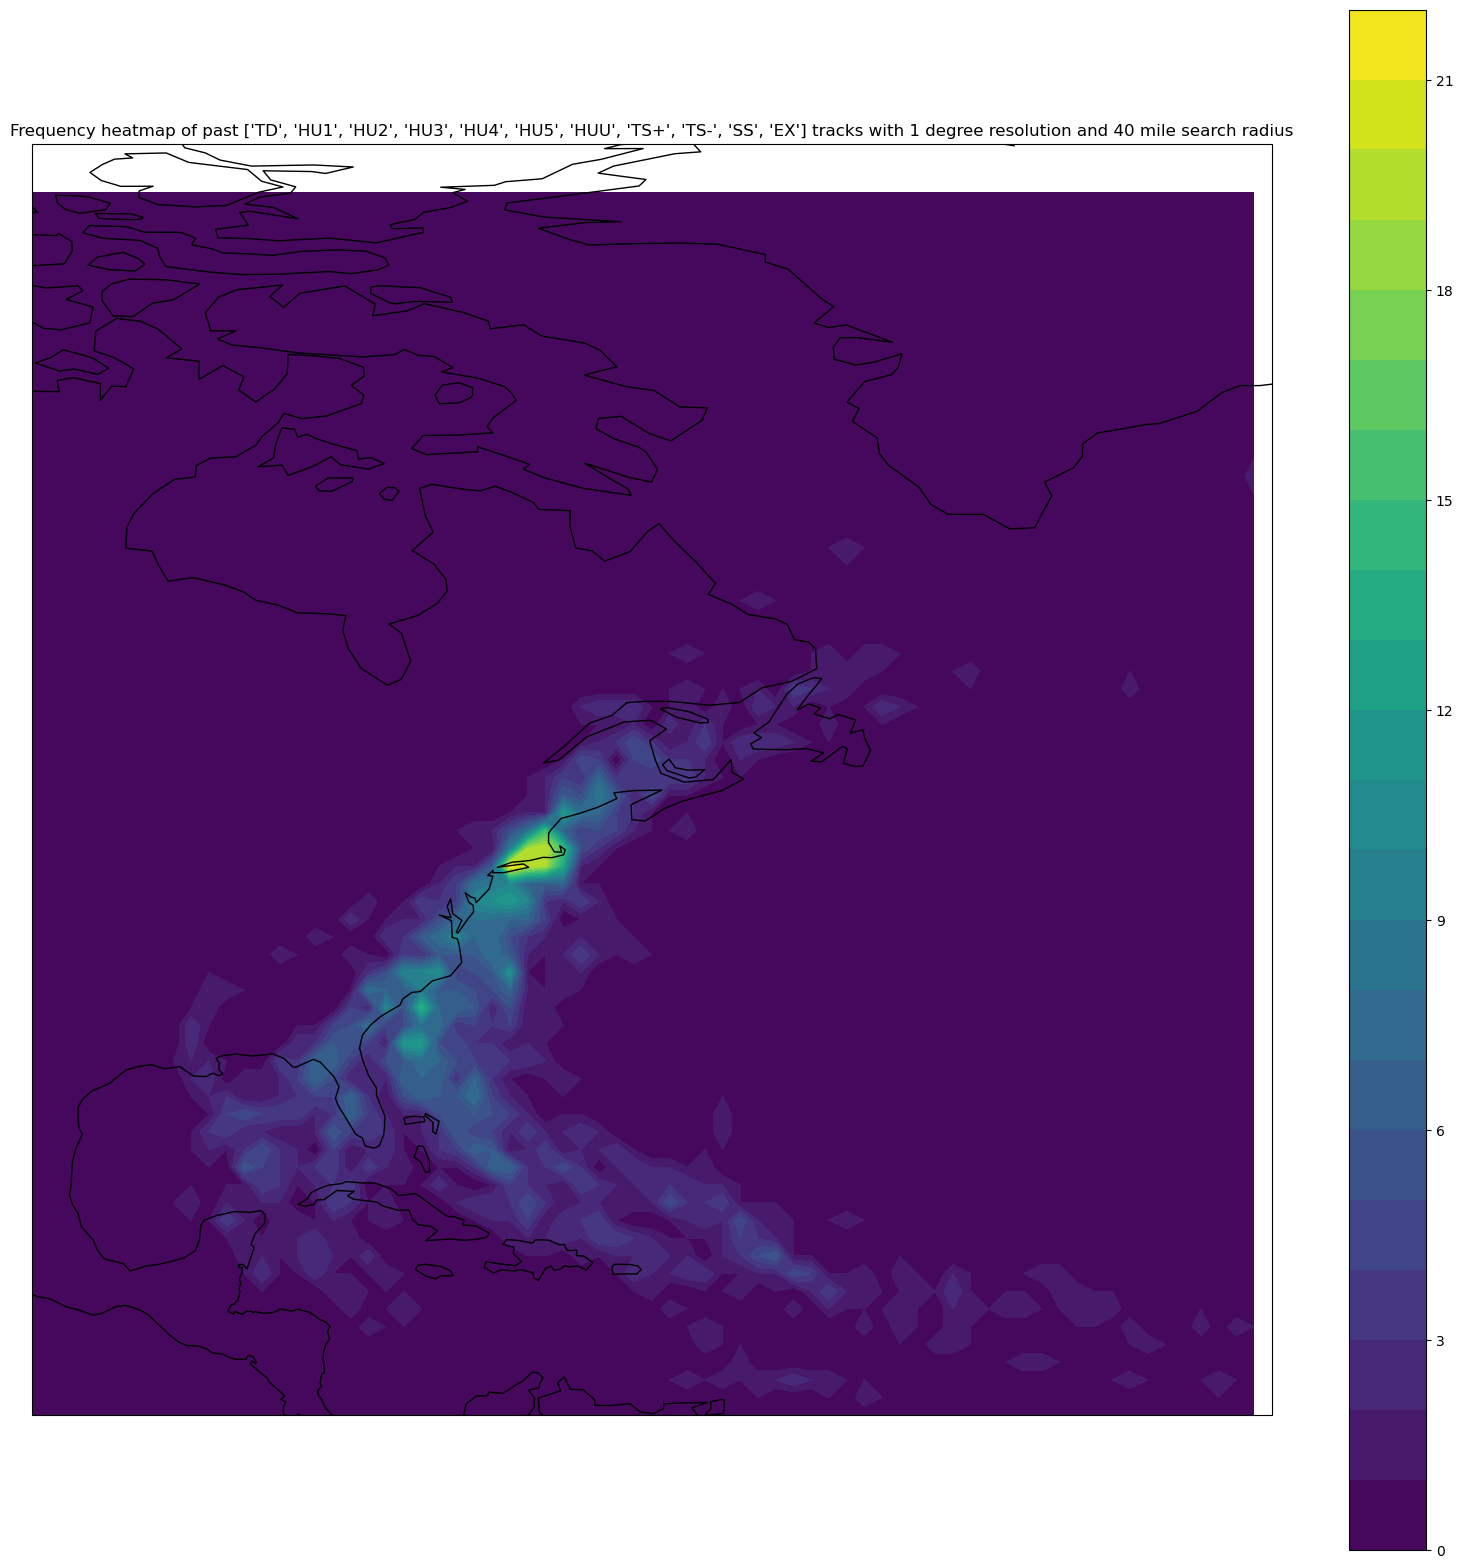

CPU times: user 5min 55s, sys: 6.94 s, total: 6min 2s
Wall time: 5min 42s


In [5]:
%%time
plot_prob_dist(hurdat, 'all', lon_min=-73, lon_max=-69.5, lat_min=41, lat_max=43, resolution = 1, saveFig = 'Plots/1-deg-heatmap')

4900


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [06:06<00:00,  5.23s/it]


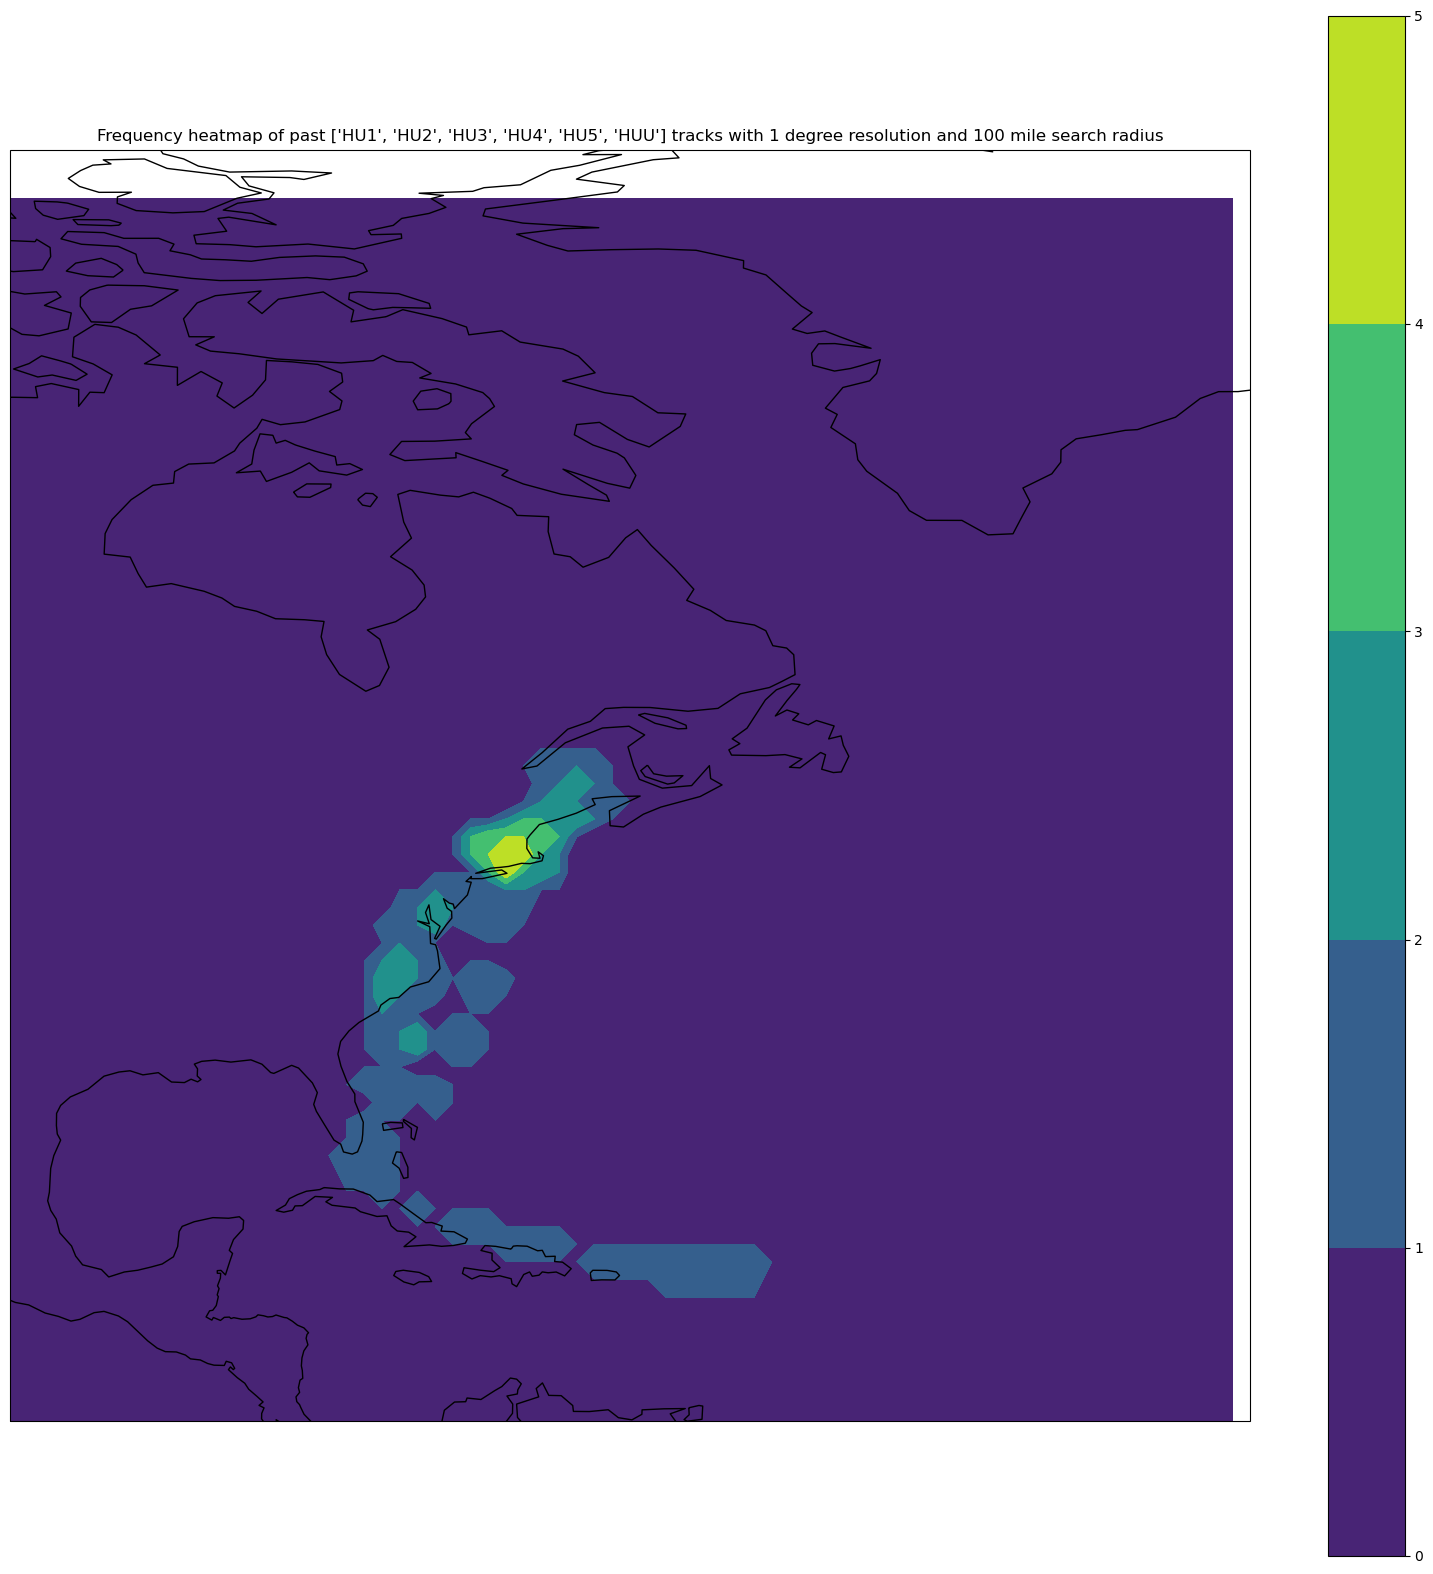

CPU times: user 6min 16s, sys: 6.32 s, total: 6min 23s
Wall time: 6min 6s


In [6]:
%%time
plot_prob_dist(hurdat, 'hurricanes', lon_min=-73, lon_max=-69.5, lat_min=41, lat_max=43, count_radius = 100, resolution = 1, saveFig = 'Plots/1-deg-hurricane-heatmap')

4900


100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [06:15<00:00,  5.37s/it]


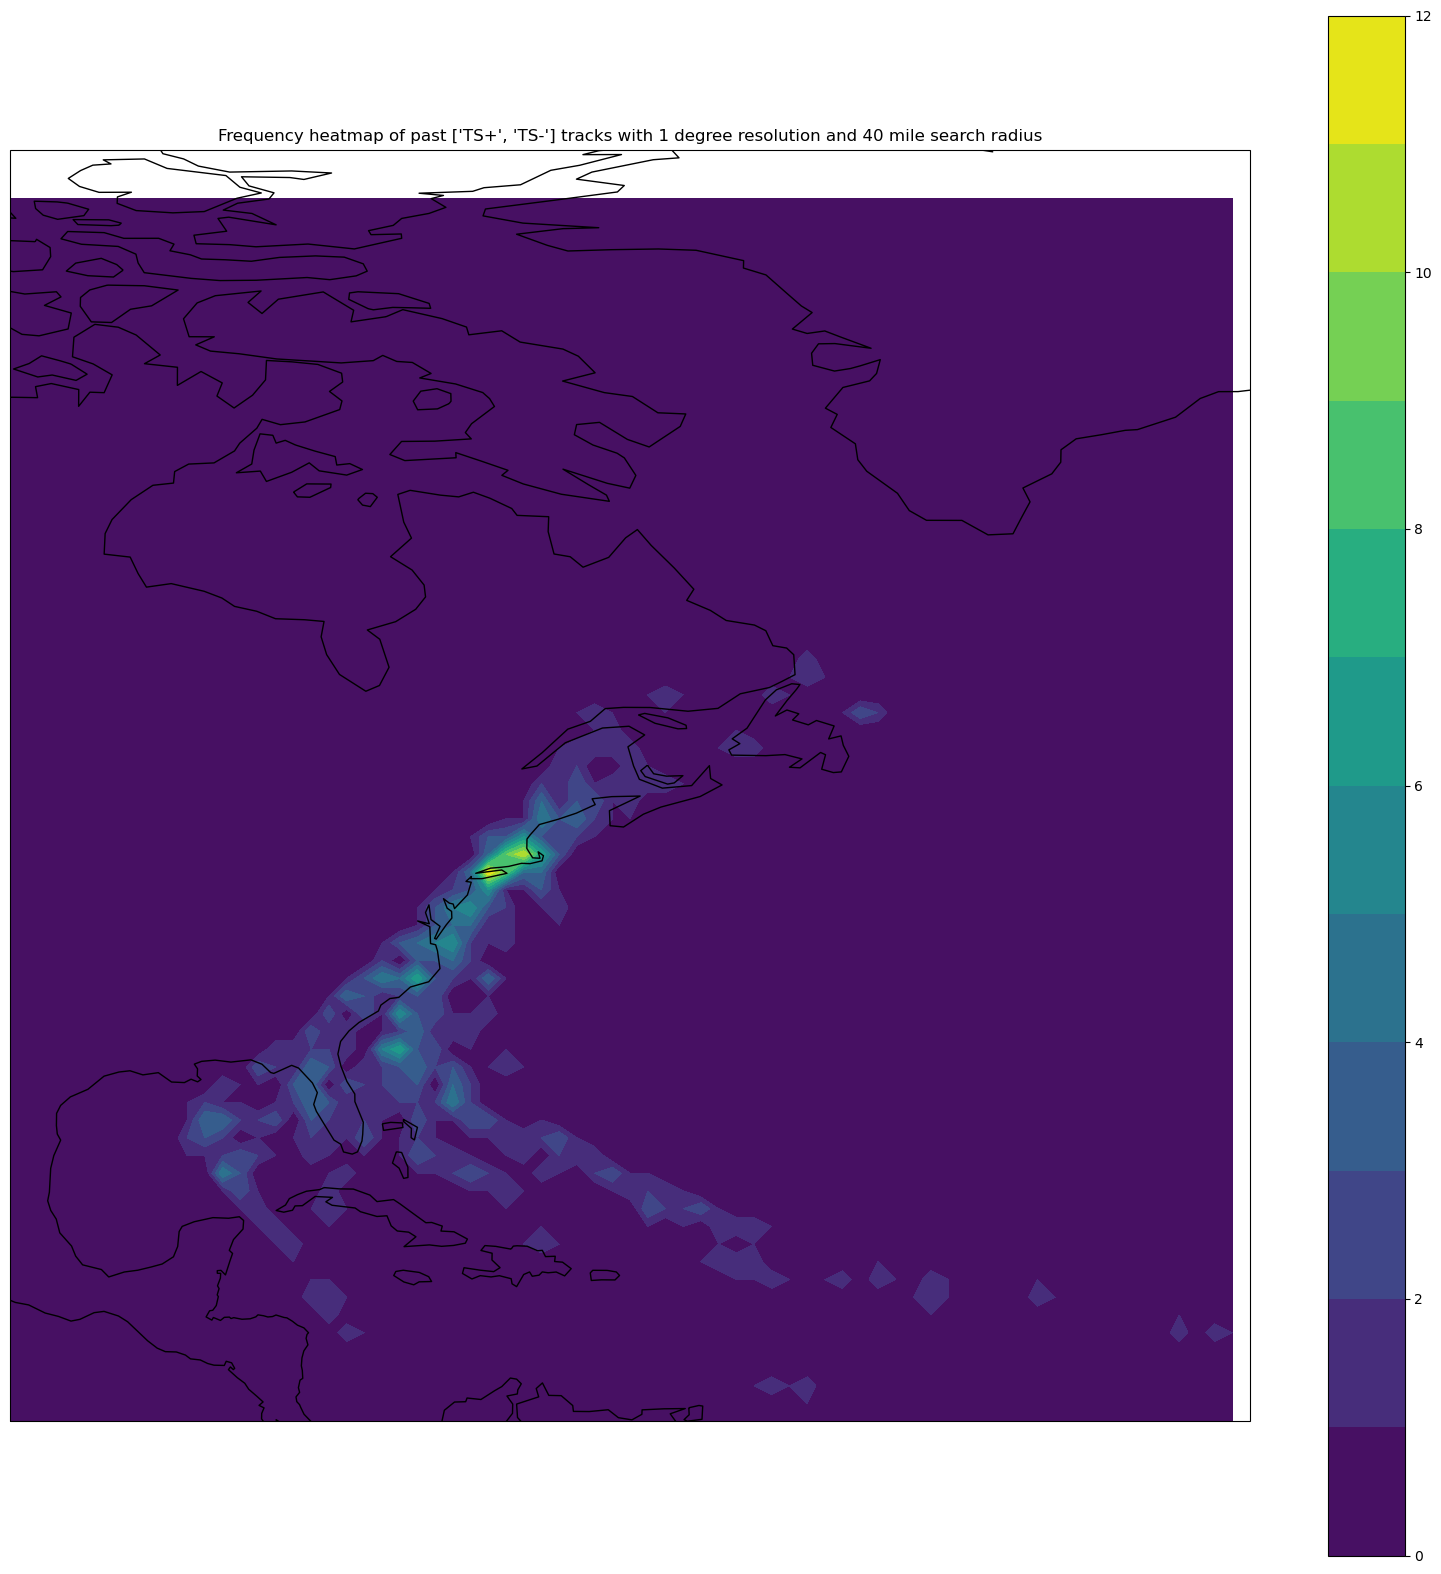

CPU times: user 6min 25s, sys: 6.85 s, total: 6min 32s
Wall time: 6min 16s


In [7]:
%%time
plot_prob_dist(hurdat, 'tropical storms', lon_min=-73, lon_max=-69.5, lat_min=41, lat_max=43, resolution = 1, saveFig = 'Plots/1-deg-tropical-storms-heatmap')